In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

class FootballStatsAnalysis:
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath, encoding='cp949')
        # self.display_info()

    def preprocess_data(self):
        # Drop unnecessary column
        self.df = self.df.drop(['Rk'], axis=1)

        # Replace values for 'Pos' column
        replace_values = {
            'DF,FW': 'FW,DF',
            'DF,MF': 'MF,DF',
            'MF,FW': 'FW,MF'
        }
        self.df['Pos'] = self.df['Pos'].replace(replace_values)

        # Impute missing values with mean
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        numeric_df = self.df.select_dtypes(include=[np.number])
        column_names = numeric_df.columns
        imputer.fit(numeric_df)
        numeric_df = imputer.transform(numeric_df)
        numeric_df = pd.DataFrame(numeric_df, columns=column_names)

        self.df[column_names] = numeric_df.round(2)
    
    def cal_defensive_score(self):
        # 가중치 설정
        weights = {
            'Won': 1.0,
            'Lost': -0.5,
            'Won%': 1.5,
            'Tkl': 1.2,
            'TklW': 1.8,
            'Def 3rd': 1.5,
            'Mid 3rd': 1.0,
            'Att 3rd': 0.8
        }

        # 정규화
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(self.df[list(weights.keys())])
        scaled_df = pd.DataFrame(scaled_features, columns=weights.keys())

        # 종합 점수 계산
        self.df['Defensive Score'] = (
            scaled_df['Won'] * weights['Won'] +
            scaled_df['Lost'] * weights['Lost'] +
            scaled_df['Won%'] * weights['Won%'] +
            scaled_df['Tkl'] * weights['Tkl'] +
            scaled_df['TklW'] * weights['TklW'] +
            scaled_df['Def 3rd'] * weights['Def 3rd'] +
            scaled_df['Mid 3rd'] * weights['Mid 3rd'] +
            scaled_df['Att 3rd'] * weights['Att 3rd']
        ).__round__(2)
        
    def display_nan_columns(self):
        column_nan = self.df.isna().any()
        print(column_nan)

    def hist_def_score_(self):
        plt.figure(figsize=(18, 10))
        plt.hist(self.df['Defensive Score'], bins=100, color='steelblue', edgecolor='black')
        plt.xlabel('Defensive Score', fontsize=20)
        plt.ylabel('Number of Players', fontsize=20)
        plt.title('Distribution of Defensive Scores')
        plt.show()  
        
    def display_info(self):
        self.df.info()

    def display_head(self):
        self.df.head()
        
    def bar_goals_and_assists_by_team(self):
        df_teams = self.df.groupby('Squad').agg({
            'Gls': 'sum',
            'Ast': 'sum',
        }).reset_index()

        # 막대차트 생성
        fig, ax = plt.subplots(figsize=(18, 10))

        # 막대의 위치 설정
        bar_width = 0.4
        index = range(len(df_teams))

        # 골과 어시스트 수 막대차트
        ax.bar([i - bar_width/2 for i in index], df_teams['Gls'], bar_width, label='Goals', color='skyblue')
        ax.bar([i + bar_width/2 for i in index], df_teams['Ast'], bar_width, label='Assists', color='lightgreen')

        ax.set_title('Goals and Assists by Team')
        ax.set_xlabel('Team', fontsize=20)
        ax.set_ylabel('Count', fontsize=20)
        ax.set_xticks(index)
        ax.set_xticklabels(df_teams['Squad'], fontsize=12, rotation=45)
        ax.tick_params(axis='y', labelsize=12)
        ax.legend()

        plt.show()

    def bar_cmp_by_team(self):
        df_teams = self.df.groupby('Squad').agg({
            'Cmp%': 'mean',
        }).reset_index()

        # 막대차트 생성
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

        ax.bar(df_teams['Squad'], df_teams['Cmp%'], color='salmon')
        ax.set_title('Pass Completion % by Team')
        ax.set_xlabel('Team', fontsize=20)
        ax.set_ylabel('Pass Completion %', fontsize=20)
        ax.tick_params(axis='x', labelsize=12, rotation=45)
        ax.tick_params(axis='y', labelsize=12)

        plt.show()

    def bar_tkl_won_by_team(self):
        df_teams = self.df.groupby('Squad').agg({
            'TklW': 'sum',
        }).reset_index()

        # 막대차트 생성
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

        ax.bar(df_teams['Squad'], df_teams['TklW'], color='orange')
        ax.set_title('Number of Tackles won by Team')
        ax.set_xlabel('Team', fontsize=20)
        ax.set_ylabel('Number of Tackles', fontsize=20)
        ax.tick_params(axis='x', labelsize=12, rotation=45)
        ax.tick_params(axis='y', labelsize=12)

        plt.show()

    def bar_aerial_won_by_team(self):
        df_teams = self.df.groupby('Squad').agg({
            'Won': 'sum',
        }).reset_index()

        # 막대차트 생성
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

        ax.bar(df_teams['Squad'], df_teams['Won'], color='yellow')
        ax.set_title('Number of aerial duels won by team')
        ax.set_xlabel('Team', fontsize=20)
        ax.set_ylabel('Number of Aerial Dues', fontsize=18)
        ax.tick_params(axis='x', labelsize=12, rotation=45)
        ax.tick_params(axis='y', labelsize=15)

        plt.show()

    def bar_concat_won_by_team(self):

        # 공중볼 경합 데이터 집계
        df_aerial = self.df.groupby('Squad').agg({
            'Won': 'sum',
        }).reset_index()
        df_aerial['Won'] = df_aerial['Won'] / 2  # 공중볼 경합 데이터를 반으로 줄이기
        df_aerial['Defensive Action'] = 'Aerial Duels Won'

        # 태클 성공횟수 데이터 집계
        df_tackle = self.df.groupby('Squad').agg({
            'TklW': 'sum',
        }).reset_index()
        df_tackle['Defensive Action'] = 'Tackles Won'

        # 칼럼 이름 통일
        df_tackle.rename(columns={'TklW': 'Count'}, inplace=True)
        df_aerial.rename(columns={'Won': 'Count'}, inplace=True)

        # 두 데이터프레임 합치기
        df_combined = pd.concat([df_aerial, df_tackle])

        # 팀 목록
        teams = df_combined['Squad'].unique()
        x = range(len(teams))

        # 막대 너비 설정
        bar_width = 0.4

        # 막대차트 생성
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

        # 각 팀별로 두 막대를 나란히 배치
        for i, defense_action in enumerate(df_combined['Defensive Action'].unique()):
            df_group = df_combined[df_combined['Defensive Action'] == defense_action]
            positions = [pos + i * bar_width for pos in x]
            ax.bar(positions, df_group['Count'], width=bar_width, label=defense_action)

        # x축 위치 조정 및 팀 이름 설정
        ax.set_xticks([pos + bar_width / 2 for pos in x])
        ax.set_xticklabels(teams, rotation=45)

        ax.set_title('Number of Aerial Duels and Tackles won by Team')
        ax.set_xlabel('Team', fontsize=15)
        ax.set_ylabel('Number of Actions', fontsize=15)
        ax.tick_params(axis='x', labelsize=12)

        # 범례 추가
        ax.legend(title='Defensive Action')

        # 레이아웃 조정
        plt.tight_layout()
        plt.show()

    def plot_assist_pie(self):
        fig = px.pie(self.df, values='Ast', names='Pos')
        fig.show()

    def plot_goals_pie_chart(self):
        fig = px.pie(self.df, values='Gls', names='Pos')
        fig.show()
        
    def plot_age_vs_average_goals(self):
        ages = np.sort(self.df['Age'].unique())
        mean_goals = self.df.groupby('Age')['Gls'].mean()
        x_values = np.linspace(np.min(ages), np.max(ages), len(ages))  # x축 값을 linspace를 사용하여 균일하게 설정
        plt.figure(figsize=(12, 8))
        plt.bar(x_values, mean_goals, width=0.8)
        plt.xticks(x_values, ages, rotation=45)
        plt.xlabel('Age')
        plt.ylabel('Average Goals')

        plt.grid(color='violet', linestyle='--')
        plt.show()

    def plot_goals_vs_age_scatter(self):
        sns.scatterplot(data=self.df, x='Age', y='Gls')
        plt.show()
        
    def plot_shots_vs_shots_on_target(self):
        self.df.plot(kind='scatter', x='Sh', y='SoT', grid=True, c='Gls', cmap='jet', figsize=(20, 8))
        plt.show()

    def assist_correlation_heatmap(self):
        selected_columns = ['Ast', 'xAG', 'A-xAG', 'xA', 'KP']
        corr_mat = self.df[selected_columns].corr(numeric_only=True)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_mat, annot=True, fmt='.2f', linewidths=.5, cmap='coolwarm')
        plt.title('Selected Features Correlation Heatmap')
        plt.show()
        
    def defense_correlation_heatmap(self):
        selected_columns = ['Defensive Score', 'PrgP', '1/3', 'Att', '90s', 'TotDist', 'Cmp', 'PrgDist']
        corr_mat = self.df[selected_columns].corr(numeric_only=True)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_mat, annot=True, fmt='.2f', linewidths=.5, cmap='coolwarm')
        plt.title('Selected Features Correlation Heatmap')
        plt.show()

# Example usage
analysis = FootballStatsAnalysis('../csv/LaLiga/2023-2024_La.csv')

# Preprocessing

In [16]:
analysis.preprocess_data()
analysis.display_nan_columns()

Player     False
Nation     False
Pos        False
Squad      False
Age         True
Born       False
90s        False
Gls        False
Sh         False
SoT        False
SoT%       False
Sh/90      False
SoT/90     False
G/Sh       False
G/SoT      False
Dist       False
FK         False
PK         False
PKatt      False
xG         False
npxG       False
npxG/Sh    False
G-xG       False
np:G-xG    False
Matches    False
Cmp        False
Att        False
Cmp%       False
TotDist    False
PrgDist    False
Ast        False
xAG        False
xA         False
A-xAG      False
KP         False
1/3        False
PPA        False
CrsPA      False
PrgP       False
Won        False
Lost       False
Won%       False
Tkl        False
TklW       False
Def 3rd    False
Mid 3rd    False
Att 3rd    False
dtype: bool


## Bar

In [ ]:
# analysis.bar_goals_and_assists_by_team()

In [ ]:
# analysis.bar_concat_won_by_team()

## Goals & Assist Pie

In [ ]:
# analysis.plot_goals_pie_chart()
# analysis.plot_assist_pie()

In [ ]:
# analysis.assist_correlation_heatmap()

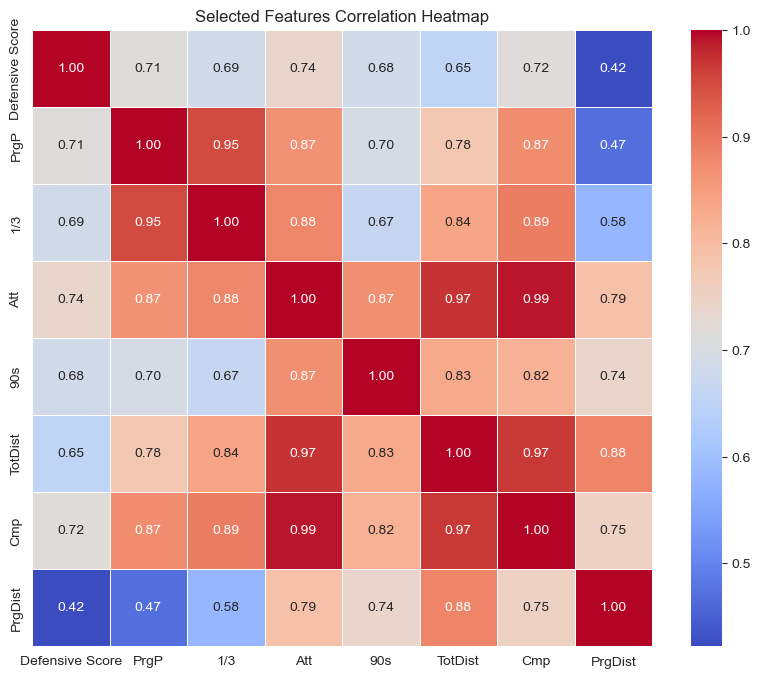

In [19]:
analysis.cal_defensive_score()
analysis.defense_correlation_heatmap()